# Feature Engineering and Classifier Evaluation: Titanic Dataset

In [47]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

## Import data set

In [68]:
df = pd.read_csv('train.csv', index_col = 0)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


## Split into training and test data

In [69]:
# First, designate X and y

y = df['Survived']

X = df.drop(columns = ['Survived']) # everything that is not the survival column

In [76]:
# Then split

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Build a baseline model

(From Monday afternoon challenges)

In [71]:
m_base = DummyClassifier(strategy='most_frequent')
m_base.fit(X, y)
y_pred_base = m_base.predict(X)
# y_pred_base

# builds an array full of 0s

## Feature engineering

From yesterday's data exploration, I noticed a few things:

- Females have a higher survival rate
- 1st class passengers have a higher survival rate, so Pclass is a likely predictor of survival
- Age: unclear. For very young and very old passengers, it looks like there are higher survival rates. But for anyone whose age is in the middle, this doesn't seem to apply.
- Higher fare has a higher survival rate

**To do:**

Ages:
- Impute missing ages using median age (to prevent outliers) by sex (to guard against distortion due to the fact that sex seems to be a much clearer predictor of survival than age)
- Rescale to make computations simpler
- Try out: is age better left as a scalar or binned e.g. by life decade?

Pclass:
- One-hot encoding

Sex:
- One-hot encoding

Fare:
- Rescale to make computations simpler
- Same as for age: better to leave as scalar or bin?

## Age

### Impute missing ages using median

In [74]:
# write a function for this so that we can repeat separately for X_train, X_test

def imputeMedianAge(df):
    # calculate median age
    median_age = df['Age'].median()
    print(median_age)

    # Actually median ages are not so far away from each other.
    # I'll use the same one for everyone and spare myself the hassle of working out how to selectively add values by gender.

    df['Age'].fillna(median_age, inplace = True)

### Run age imputation on both data sets

28.0
29.0


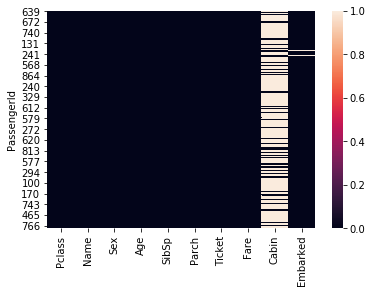

In [80]:
# first: list of two data sets.

sets = [X_train, X_test]

for item in sets:
    imputeMedianAge(item)
    
# sns.heatmap(X_test.isna())

### Normalise age: rescale 0 - 1 for test and training data

In [157]:
# function for normalising age
def normalise(df, column):

    # Calculate range
    normalised = df[str(column)].max() - df[str(column)].min()
    col_name = str(column) + '_Scaled'

    # Add new column with scaled values
    df[col_name] = ( df[str(column)] - df[str(column)].min() ) / normalised

In [158]:
# run function on both data sets

for item in sets:
    normalise(item, 'Age')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Passenger class: one-hot encoding

In [149]:
# one-hot encoding function
def onehotEncode(df, column): # as it turns out in pandas, DataFrames do not have .name attribute i.e. you can't just pull the name of a data frame out of it. Ugh
    onehot = pd.get_dummies(df[str(column)])
    # get column names and rename them
    cols = onehot.columns
    new_cols = []
    for i in range(0, len(cols)):
        new_cols.append(str(column) + str(onehot.columns[i]))
    # rename
    onehot.columns = new_cols
    return onehot



In [151]:
# because dfs do not have name attributes, I wasn't able to work out a way to make a for loop that would label the different one-hot frames with the names of their parent df
# so need to call this function separately

onehot_X_train_Pclass = onehotEncode(X_train, 'Pclass')
onehot_X_test_Pclass = onehotEncode(X_test, 'Pclass')

,Pclass1,Pclass2,Pclass3
PassengerId,,,
385,0,0,1
210,1,0,0
124,0,1,0
159,0,0,1
544,0,1,0
...,...,...,...
889,0,0,1
115,0,0,1
873,1,0,0


### One-hot encoding for sex

In [153]:
onehot_X_train_Sex = onehotEncode(X_train, 'Sex')
onehot_X_test_Sex = onehotEncode(X_test, 'Sex')

,Sexfemale,Sexmale
PassengerId,,
639,1,0
570,0,1
2,1,0
785,0,1
367,1,0
...,...,...
354,0,1
315,0,1
766,1,0


## Join data together

In [156]:
# X_train

X_train_engineered = pd.concat([X_train, onehot_X_train_Sex, onehot_X_train_Pclass], axis = 1)

# X_test

X_test_engineered = pd.concat([X_test, onehot_X_test_Sex, onehot_X_test_Pclass], axis = 1)

## Normalise fares

In [ ]:
normalise(X_train_engineered, ''